In [1]:
import os, sys
from pathlib import Path
import json
import re

import pandas as pd

from transformers import AutoTokenizer

import matplotlib.pyplot as plt
import seaborn as sns

WORK_DIR = Path.cwd().parent

sys.path.append(str(WORK_DIR))

from src import (
    main,
    graph_gen,
    ollama_manager,
    prompt_formatters,
    batch_processor
)
from src.datasets import STARDataset


Disabling PyTorch because PyTorch >= 2.1 is required but found 2.0.0
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
STAR_VAL_PATH = WORK_DIR / "data/datasets/STAR/STAR_annotations/STAR_val.json"
GEN_GRAPH_PATH = WORK_DIR / "outputs/gen_stsg_gemma3:12b-it-qat_20250522_14:30_99.jsonl"
GT_GRAPH_PATH = WORK_DIR / "data/datasets/STAR_verbalized_stsg_val.json"


In [3]:
user_promp_format = main._load_prompt_fromfile(WORK_DIR / "data/prompts/graph-sim/usr_prompt.txt")
pformatter = prompt_formatters.PromptFormatter(user_promp_format, fields=['gen-stsg', 'gt-stsg'])


In [4]:
sample = {'gt-stsg': 'BBBBBBBBBBBBBBBB', 'gen-stsg': 'AAAAAAAAAAAAAaa'}
print(pformatter.format(sample))


You are tasked with comparing generated Spatio-Temporal Scene Graphs (STSGs) against ground truth representations to determine their correctness.

CONSIDER A GENERATED STSG CORRECT IF:
- All major entities from the ground truth are present (allowing for hyponyms/synonyms)
- Spatial and temporal relationships are accurately represented
- Minor descriptive additions don't contradict the ground truth

CONSIDER A GENERATED STSG INCORRECT IF ANY OF THESE ERRORS OCCUR:
- Missing Critical Entity: Major entities from ground truth are absent in frames where they should appear
- Incorrect Spatial Relationships: Wrong predicates describing spatial connections (e.g., "on" vs "under", "left_of" vs "right_of")
- Incorrect Temporal Relationships: Wrong predicates describing temporal sequences (e.g., "before" vs "after", "during" vs "outside")
- Temporal Misalignment: Entities or relationships appearing in wrong time frames or durations
- Contradictory Predicates: Relationships that directly contradic

In [5]:
star = []
with open(STAR_VAL_PATH, 'r') as f:
    star = json.load(f)
    
star_df = pd.DataFrame(star)


In [6]:
gen_stsg = []
with open(GEN_GRAPH_PATH, 'r') as f:
    gen_stsg = [json.loads(line) for line in f.readlines()]
    
gen_stsg_df = pd.DataFrame(gen_stsg)
gen_stsg_df.iloc[0]


video_id                                                    6H78U
start                                                        15.6
end                                                          22.7
chat_history    [{'role': 'user', 'content': 'Look carefully a...
stsg            \nFrame 0:\n\nyoung_man ---- standing_on ---- ...
Name: 0, dtype: object

In [7]:
gt_stsg = []
with open(GT_GRAPH_PATH, 'r') as f:
    gt_stsg = json.load(f)
    

gt_stsg_df = pd.DataFrame(gt_stsg)
gt_stsg_df.iloc[0]


question_id                                    Interaction_T1_13
video_id                                                   6H78U
start                                                       11.1
end                                                         19.6
stsg           Frame 000198\n\tperson --- on_the_side_of --- ...
Name: 0, dtype: object

In [8]:
gen_stsg_df.shape, gen_stsg_df[['video_id', 'start', 'end']].value_counts().shape


((1094, 5), (870,))

In [9]:
unique_by_vid_gen = gen_stsg_df.groupby(['video_id', 'start', 'end']).nth(0)
unique_by_vid_gen = unique_by_vid_gen.rename(columns={'stsg': 'gen-stsg'})
unique_by_vid_gen = unique_by_vid_gen.drop(columns=['chat_history'])
unique_by_vid_gen


,video_id,start,end,gen-stsg
0,6H78U,15.6,22.7,\nFrame 0:\n\nyoung_man ---- standing_on ---- ...
1,RNLTR,11.6,16.4,\nFrame 0:\n\nwoman ---- standing_in_front_of ...
2,VNQTH,2.7,9.2,\nFrame 0:\n\n\nwoman ---- wearing ---- white_...
3,Y79PC,16.9,22.6,\nFrame 0:\n\n\nwoman ---- standing_in ---- ro...
4,4GLAP,15.7,21.4,\nFrame 0:\n\nyoung_man ---- holding ---- plas...
...,...,...,...,...
1086,FRLW2,25.7,32.0,\nFrame 0:\n\n\nwoman ---- standing_in_front_o...
1088,3W6TL,13.1,20.1,\nFrame 0:\n\nbed ---- against ---- wall\nnigh...
1090,86GSE,10.1,20.0,\nFrame 0:\n\nwoman ---- wearing ---- red_dres...
1091,9J166,18.6,23.0,\nFrame 0:\n\nwoman ---- looking_at ---- windo...


In [10]:
unique_by_vid_gt = gt_stsg_df.groupby(['video_id', 'start', 'end']).agg({
    'stsg': 'first',
    'question_id': list       # Collect all 'question_id's into a list
}).rename(columns={'question_id': 'q_ids', 'stsg': 'gt-stsg'}).reset_index()

unique_by_vid_gt


,video_id,start,end,gt-stsg,q_ids
0,013SD,0.0,4.30,Frame 000010\n\tperson --- holding --- box\n\t...,"[Interaction_T1_7912, Interaction_T2_6864, Int..."
1,01KML,18.1,26.80,Frame 000569\n\tperson --- standing_on --- flo...,"[Interaction_T1_4892, Interaction_T2_4264, Int..."
2,01ZWG,4.9,11.00,Frame 000080\n\tperson --- in_front_of --- tab...,"[Interaction_T1_2724, Interaction_T2_2495, Int..."
3,01ZWG,4.9,13.50,Frame 000080\n\tperson --- in_front_of --- tab...,"[Sequence_T1_2453, Sequence_T2_1855, Sequence_..."
4,01ZWG,7.2,13.50,Frame 000103\n\tperson --- touching --- table\...,"[Interaction_T1_2725, Interaction_T2_2496]"
...,...,...,...,...,...
3368,ZZ89F,0.0,9.60,Frame 000010\n\ttowel --- near --- shoe\nFrame...,"[Feasibility_T3_81, Feasibility_T4_81, Feasibi..."
3369,ZZ89F,0.0,15.35,Frame 000072\n\tperson --- in_front_of --- ref...,[Prediction_T1_2530]
3370,ZZ89F,7.4,13.50,Frame 000072\n\tperson --- in_front_of --- ref...,[Feasibility_T5_2154]
3371,ZZ89F,13.6,20.60,Frame 000129\n\tperson --- on_the_side_of --- ...,[Interaction_T1_8201]


In [11]:
r_df = unique_by_vid_gen.merge(
    unique_by_vid_gt,
    on=['video_id', 'start', 'end'],
    how='left'
)
# add qid for prompt compatibiliy 
r_df['qid'] = r_df.apply(lambda x: x['q_ids'][0], axis=1)
r_df['prompt'] = r_df.apply(lambda x: pformatter.format(x), axis=1)
r_df


,video_id,start,end,gen-stsg,gt-stsg,q_ids,qid,prompt
0,6H78U,15.6,22.7,\nFrame 0:\n\nyoung_man ---- standing_on ---- ...,Frame 000286\n\tperson --- holding --- towel\n...,[Interaction_T1_14],Interaction_T1_14,You are tasked with comparing generated Spatio...
1,RNLTR,11.6,16.4,\nFrame 0:\n\nwoman ---- standing_in_front_of ...,Frame 000194\n\tperson --- on_the_side_of --- ...,[Interaction_T1_32],Interaction_T1_32,You are tasked with comparing generated Spatio...
2,VNQTH,2.7,9.2,\nFrame 0:\n\n\nwoman ---- wearing ---- white_...,Frame 000043\n\tperson --- holding --- clothes...,"[Interaction_T1_40, Interaction_T2_31]",Interaction_T1_40,You are tasked with comparing generated Spatio...
3,Y79PC,16.9,22.6,\nFrame 0:\n\n\nwoman ---- standing_in ---- ro...,Frame 000525\n\tperson --- wearing --- clothes...,"[Interaction_T1_43, Interaction_T2_35]",Interaction_T1_43,You are tasked with comparing generated Spatio...
4,4GLAP,15.7,21.4,\nFrame 0:\n\nyoung_man ---- holding ---- plas...,Frame 000100\n\tperson --- holding --- shoe\n\...,"[Interaction_T1_71, Interaction_T4_21, Interac...",Interaction_T1_71,You are tasked with comparing generated Spatio...
...,...,...,...,...,...,...,...,...
865,FRLW2,25.7,32.0,\nFrame 0:\n\n\nwoman ---- standing_in_front_o...,Frame 000811\n\tperson --- standing_on --- flo...,"[Interaction_T1_6052, Interaction_T2_5259]",Interaction_T1_6052,You are tasked with comparing generated Spatio...
866,3W6TL,13.1,20.1,\nFrame 0:\n\nbed ---- against ---- wall\nnigh...,Frame 000401\n\tperson --- on_the_side_of --- ...,[Interaction_T2_5312],Interaction_T2_5312,You are tasked with comparing generated Spatio...
867,86GSE,10.1,20.0,\nFrame 0:\n\nwoman ---- wearing ---- red_dres...,Frame 000310\n\tperson --- beneath --- sofa/co...,"[Interaction_T1_6161, Interaction_T2_5357]",Interaction_T1_6161,You are tasked with comparing generated Spatio...
868,9J166,18.6,23.0,\nFrame 0:\n\nwoman ---- looking_at ---- windo...,Frame 000562\n\tperson --- holding --- book\n\...,[Interaction_T2_5369],Interaction_T2_5369,You are tasked with comparing generated Spatio...


In [12]:
print(r_df.iloc[0]['prompt'])


You are tasked with comparing generated Spatio-Temporal Scene Graphs (STSGs) against ground truth representations to determine their correctness.

CONSIDER A GENERATED STSG CORRECT IF:
- All major entities from the ground truth are present (allowing for hyponyms/synonyms)
- Spatial and temporal relationships are accurately represented
- Minor descriptive additions don't contradict the ground truth

CONSIDER A GENERATED STSG INCORRECT IF ANY OF THESE ERRORS OCCUR:
- Missing Critical Entity: Major entities from ground truth are absent in frames where they should appear
- Incorrect Spatial Relationships: Wrong predicates describing spatial connections (e.g., "on" vs "under", "left_of" vs "right_of")
- Incorrect Temporal Relationships: Wrong predicates describing temporal sequences (e.g., "before" vs "after", "during" vs "outside")
- Temporal Misalignment: Entities or relationships appearing in wrong time frames or durations
- Contradictory Predicates: Relationships that directly contradic

In [13]:
prompts = r_df.to_dict('records')
prompts[0]


{'video_id': '6H78U',
 'start': 15.6,
 'end': 22.7,
 'gen-stsg': '\nFrame 0:\n\nyoung_man ---- standing_on ---- floor\nyoung_man ---- looking_at ---- camera\nyoung_man ---- in_front_of ---- sofa\nsofa ---- against ---- wall\nsofa ---- has ---- pillow\npillow ---- resting_on ---- sofa\nfloor ---- beneath ---- sofa\nfloor ---- beneath ---- young_man\nwall ---- behind ---- sofa\nwindow ---- behind ---- young_man\nwindow ---- adjacent_to ---- wall\ncurtains_or_blinds ---- covering ---- window\nlight_fixture ---- mounted_on ---- wall\nlight_fixture ---- above ---- sofa\n\nFrame 1:\n\nman ---- holding ---- pillow\nman ---- standing_in_front_of ---- sofa\npillow ---- on ---- sofa\nsofa ---- against ---- wall\nair_conditioning_unit ---- mounted_on ---- wall\nelectrical_outlet ---- on ---- wall\nair_conditioning_unit ---- above ---- electrical_outlet\nfloor ---- beneath ---- sofa\nfloor ---- beneath ---- man\nman ---- wearing ---- sandals\nsofa ---- has ---- armrest\nsofa ---- has ---- backrest

In [14]:
hugg_key = os.environ['HUGGINGFACE_KEY']

tokenizer = AutoTokenizer.from_pretrained(
                'google/gemma-3-4b-it', 
                token=hugg_key)


In [15]:
r_df.iloc[0]["prompt"]


'You are tasked with comparing generated Spatio-Temporal Scene Graphs (STSGs) against ground truth representations to determine their correctness.\n\nCONSIDER A GENERATED STSG CORRECT IF:\n- All major entities from the ground truth are present (allowing for hyponyms/synonyms)\n- Spatial and temporal relationships are accurately represented\n- Minor descriptive additions don\'t contradict the ground truth\n\nCONSIDER A GENERATED STSG INCORRECT IF ANY OF THESE ERRORS OCCUR:\n- Missing Critical Entity: Major entities from ground truth are absent in frames where they should appear\n- Incorrect Spatial Relationships: Wrong predicates describing spatial connections (e.g., "on" vs "under", "left_of" vs "right_of")\n- Incorrect Temporal Relationships: Wrong predicates describing temporal sequences (e.g., "before" vs "after", "during" vs "outside")\n- Temporal Misalignment: Entities or relationships appearing in wrong time frames or durations\n- Contradictory Predicates: Relationships that dire

In [16]:
resp_token_len = pd.Series(r_df.index)

for index, row in r_df.iterrows():
    resp_token_len.loc[index] = len(tokenizer.encode(row['prompt']))

resp_token_len.sort_values().value_counts(sort=False)


3056    1
3134    1
3228    1
3229    1
3309    1
       ..
6892    1
6922    1
6991    1
7146    1
7610    1
Name: count, Length: 708, dtype: int64

count     870.000000
mean     4393.551724
std       698.480601
min      3056.000000
25%      3857.500000
50%      4262.000000
75%      4754.000000
max      7610.000000
dtype: float64

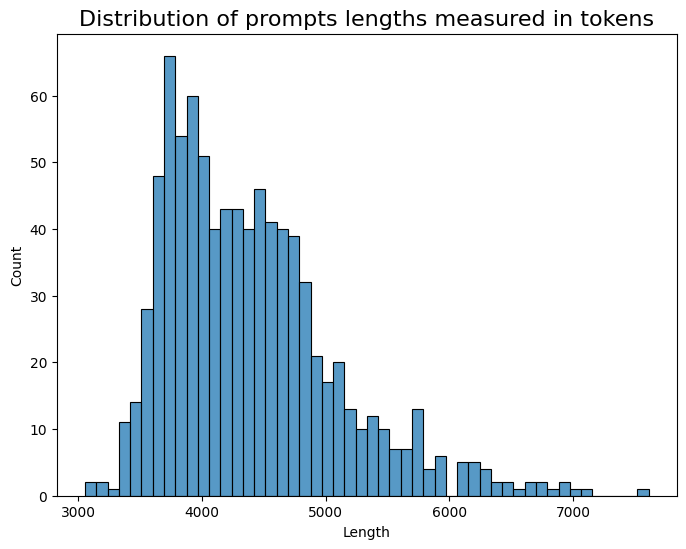

In [17]:
plt.figure(figsize=(8, 6))
sns.histplot(resp_token_len, bins=50)
plt.title("Distribution of prompts lengths measured in tokens", fontsize=16)
plt.xlabel("Length")
plt.ylabel("Count")

resp_token_len.describe()


## Load LLM evluation on graph similarity

In [18]:
similarity_responses_df = None
with open(WORK_DIR / "outputs/sim_between_frames_v2_gemma3:4b-it-qat_20250604_10:19:00.jsonl", 'r') as f:
    similarity_responses_df = pd.DataFrame([json.loads(line) for line in f.readlines()])
    



count     870.000000
mean      430.865517
std       302.514452
min        80.000000
25%       154.000000
50%       443.500000
75%       659.750000
max      2049.000000
dtype: float64

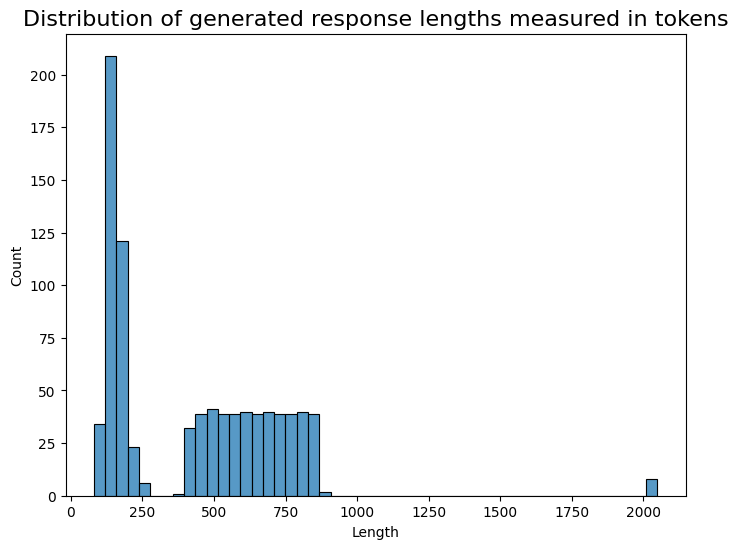

In [19]:
resp_token_len = pd.Series(r_df.index)

for index, row in similarity_responses_df.iterrows():
    resp_token_len.loc[index] = len(tokenizer.encode(row['response']))

resp_token_len.sort_values().value_counts(sort=False)

plt.figure(figsize=(8, 6))
sns.histplot(resp_token_len, bins=50)
plt.title("Distribution of generated response lengths measured in tokens", fontsize=16)
plt.xlabel("Length")
plt.ylabel("Count")

resp_token_len.describe()


In [20]:
similarity_responses = []
with open(WORK_DIR / "outputs/sim_between_frames_gemma3:4b-it-qat_20250603_16:33:99.jsonl", 'r') as f:
    similarity_responses = [json.loads(line) for line in f.readlines()]
    

ans_regex_pattern = r'(?i:final\s*answer):\s*((?:\w+(?:\s|\/)?){,10})'
contains_answer = similarity_responses_df['response'].str.contains(ans_regex_pattern, case=False, regex=True, flags=re.DOTALL)


print(f"Answer following the template: {contains_answer.value_counts()[True]}\n"
      f"{contains_answer.value_counts()[True]/similarity_responses_df.shape[0]:.2%} of the total")

print(f"\nOnly {contains_answer.value_counts()[False]} samples do not contain the answer in the response with the specified format")



Answer following the template: 395
98.01% of the total

Only 8 samples do not contain the answer in the response with the specified format


/tmp/ipykernel_257304/3267174972.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_answer = similarity_responses_df['response'].str.contains(ans_regex_pattern, case=False, regex=True, flags=re.DOTALL)


In [21]:
ans_df = \
    similarity_responses_df[contains_answer]['response'] \
    .apply(lambda x: re.findall(ans_regex_pattern, x)[-1].strip()) \
    .to_frame(name='text')

ans_df
ans_df.rename(columns={0: 'text'}, inplace=True)

ans_df['text'] = ans_df['text'].str.strip()
ans_df['response'] = similarity_responses_df[contains_answer]['response']
ans_df


,text,response
0,INCORRECT,Assessment:\n\nThe generated STSG is significa...
1,INCORRECT,Assessment: The generated STSG contains severa...
2,CORRECT,Assessment:\n\nThe generated STSG is largely c...
3,INCORRECT,Assessment:\n\nThe generated STSG is incorrect...
4,INCORRECT,Assessment:\n\nThe generated STSG is generally...
...,...,...
398,INCORRECT,Assessment:\n\nThe generated STSG contains sev...
399,INCORRECT,Assessment:\n\nThe generated STSG captures the...
400,INCORRECT,Assessment:\n\nThe generated STSG contains sev...
401,INCORRECT,Assessment:\n\nThe generated STSG contains sev...


In [22]:
## extract also the error type
similarity_responses = []
with open(WORK_DIR / "outputs/sim_between_frames_gemma3:4b-it-qat_20250603_16:33:99.jsonl", 'r') as f:
    similarity_responses = [json.loads(line) for line in f.readlines()]
    

ans_regex_pattern = r'(?i:error\s*type):\s*((?:\w+(?:\s|\/)?){,10})'
contains_answer = similarity_responses_df['response'].str.contains(ans_regex_pattern, case=False, regex=True, flags=re.DOTALL)


print(f"Answer following the template: {contains_answer.value_counts()[True]}\n"
      f"{contains_answer.value_counts()[True]/similarity_responses_df.shape[0]:.2%} of the total")

print(f"\nOnly {contains_answer.value_counts()[False]} samples do not contain the answer in the response with the specified format")

ans_df['error_type'] = \
    similarity_responses_df[contains_answer]['response'] \
    .apply(lambda x: re.findall(ans_regex_pattern, x)[-1].strip())

ans_df


Answer following the template: 395
98.01% of the total

Only 8 samples do not contain the answer in the response with the specified format


/tmp/ipykernel_257304/2464830695.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_answer = similarity_responses_df['response'].str.contains(ans_regex_pattern, case=False, regex=True, flags=re.DOTALL)


,text,response,error_type
0,INCORRECT,Assessment:\n\nThe generated STSG is significa...,Missing critical entity and incorrect spatial ...
1,INCORRECT,Assessment: The generated STSG contains severa...,Incorrect Spatial Relationships
2,CORRECT,Assessment:\n\nThe generated STSG is largely c...,Missing spatial detail/precision
3,INCORRECT,Assessment:\n\nThe generated STSG is incorrect...,Missing critical entity
4,INCORRECT,Assessment:\n\nThe generated STSG is generally...,Missing critical entity
...,...,...,...
398,INCORRECT,Assessment:\n\nThe generated STSG contains sev...,Incorrect Spatial Relationships
399,INCORRECT,Assessment:\n\nThe generated STSG captures the...,Incorrect Spatial Relationships
400,INCORRECT,Assessment:\n\nThe generated STSG contains sev...,Missing critical entity
401,INCORRECT,Assessment:\n\nThe generated STSG contains sev...,Incorrect Spatial Relationships


In [23]:
ans_df['text'].value_counts()


text
INCORRECT    391
CORRECT        4
Name: count, dtype: int64

In [24]:
ans_df['error_type'].value_counts()


error_type
Missing critical entity                                                           237
Incorrect Spatial Relationships                                                    87
Missing critical entity and incorrect spatial relationships                        16
Semantic inconsistency                                                              7
Minor spatial/temporal relationship discrepancies                                   3
Spatial Relationships                                                               2
Missing critical entity and Incorrect spatial relationships                         2
Incorrect Spatial Relationships and Semantic Inconsistency                          2
Missing critical entity and Incorrect Spatial Relationships                         2
Semantic Inconsistency                                                              2
Missing critical entity and incorrect spatial/temporal relationships                2
Missing spatial detail/precision           

In [25]:
print(similarity_responses_df.iloc[0]['response'])


Assessment:

The generated STSG is significantly different from the ground truth. While it captures some of the objects present (laptop, countertop, stove, etc.), it fails to represent the core relationship of the person holding the dish. The generated graph describes the person as "behind" the laptop, which is incorrect. The relationship "holding" is missing entirely. The generated graph also misrepresents the spatial relationships, placing the person "behind" the laptop instead of in front of it.

Error Type: Missing critical entity and incorrect spatial relationships.

Final Answer: INCORRECT


In [26]:
print(similarity_responses_df.iloc[2]['response'])


Assessment:

The generated STSG is largely correct, but it misses some of the finer details present in the ground truth. Specifically, the generated STSG doesn't consistently capture the spatial relationships as accurately as the ground truth. For example, in Frame 0, the generated STSG describes the bed as "positioned against the wall," which is accurate, but the ground truth explicitly states the bed is "positioned *against* the wall," emphasizing the direct contact. Similarly, the generated STSG doesn't always capture the precise placement of objects relative to each other.

The generated STSG does a good job of representing the core entities (person, bed, pillows, etc.) and their basic relationships. However, it lacks the level of detail and precision found in the ground truth.

Error type: Missing spatial detail/precision.

Final Answer: CORRECT

